<a href="https://colab.research.google.com/github/aminayusif/Intrudex/blob/main/Intrudex_Cybersecurity_Intrusion_Detection_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction

This notebook performs an exploratory data analysis and builds machine learning models to detect cybersecurity intrusions. The analysis includes data preprocessing, feature engineering, handling class imbalance, training and evaluating several supervised learning models (Logistic Regression, Random Forest, Decision Tree, and XGBoost), and applying unsupervised learning techniques (K-Means Clustering and Isolation Forest) for anomaly detection. The goal is to identify patterns associated with malicious activities and build models that can effectively predict potential intrusions.

### Table of Contents

- Data Loading and Initial Exploration
- Data Preprocessing and Feature Engineering
- Handling Class Imbalance
- Supervised Learning Models (Training and Evaluation)
- Unsupervised Learning (K-Means and Isolation Forest)
- Model Interpretation with SHAP
- Summary and Conclusion

#### Data Loading and Initial Exploration

This section covers loading the dataset and performing initial checks such as viewing the head of the dataframe, checking data types and non-null counts, and examining missing values.

#### Data Preprocessing and Feature Engineering

This section details the steps taken to prepare the data for modeling. This includes:
- Dropping irrelevant columns (`session_id`).
- Handling missing values in the `encryption_used` column by imputing with the mode.
- Creating new features such as the `failed_login_ratio`.
- Generating polynomial features (`login_attempts_sq`, `failed_logins_sq`).

#### Handling Class Imbalance

The notebook addresses the class imbalance in the target variable (`attack_detected`) using the Synthetic Minority Over-sampling Technique (SMOTE). Visualizations are included to show the class distribution before and after applying SMOTE.

#### Supervised Learning Models (Training and Evaluation)

This section focuses on building and evaluating supervised learning models:
- The preprocessed and resampled data is split into training and testing sets.
- Logistic Regression, Random Forest, Decision Tree, and XGBoost models are trained and evaluated using GridSearchCV for hyperparameter tuning.
- Performance metrics (accuracy, recall, precision, ROC AUC) are calculated and presented in a table, along with classification reports for each model.
- ROC AUC curves for all models are plotted for visual comparison.

#### Unsupervised Learning (K-Means and Isolation Forest)

This section explores unsupervised learning techniques for anomaly detection:
- K-Means clustering is applied to identify potential groupings in the data, and the Elbow method is used to suggest an optimal number of clusters.
- The clustering results are visualized using scatter plots.
- Isolation Forest is applied to detect anomalies, and the distribution of anomaly scores is visualized.

#### Model Interpretation with SHAP

SHAP (SHapley Additive exPlanations) is used to interpret the Isolation Forest model, providing insights into which features are most influential in determining anomaly scores. A summary plot and a force plot are included to illustrate the SHAP analysis.

#### Summary and Conclusion

This section summarizes the key findings from both the supervised and unsupervised learning analyses, highlighting the performance of the models and insights gained from the data and model interpretation. Possible next steps are also suggested.

## Exploratory data analysis and data preprocessing

### Import common libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Load dataset

In [ ]:
data=pd.read_csv('/content/cybersecurity_intrusion_data.csv')

### Inspect dataset

In [ ]:
data.head()

,session_id,network_packet_size,protocol_type,login_attempts,session_duration,encryption_used,ip_reputation_score,failed_logins,browser_type,unusual_time_access,attack_detected
0,SID_00001,599,TCP,4,492.983263,DES,0.606818,1,Edge,0,1
1,SID_00002,472,TCP,3,1557.996461,DES,0.301569,0,Firefox,0,0
2,SID_00003,629,TCP,3,75.044262,DES,0.739164,2,Chrome,0,1
3,SID_00004,804,UDP,4,601.248835,DES,0.123267,0,Unknown,0,1
4,SID_00005,453,TCP,5,532.540888,AES,0.054874,1,Firefox,0,0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9537 entries, 0 to 9536
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   session_id           9537 non-null   object 
 1   network_packet_size  9537 non-null   int64  
 2   protocol_type        9537 non-null   object 
 3   login_attempts       9537 non-null   int64  
 4   session_duration     9537 non-null   float64
 5   encryption_used      7571 non-null   object 
 6   ip_reputation_score  9537 non-null   float64
 7   failed_logins        9537 non-null   int64  
 8   browser_type         9537 non-null   object 
 9   unusual_time_access  9537 non-null   int64  
 10  attack_detected      9537 non-null   int64  
dtypes: float64(2), int64(5), object(4)
memory usage: 819.7+ KB


Dataset has 11 columns and 9537 rows

Check for null values in dataset

In [ ]:
data.isnull().sum()

,0
session_id,0
network_packet_size,0
protocol_type,0
login_attempts,0
session_duration,0
encryption_used,1966
ip_reputation_score,0
failed_logins,0
browser_type,0
unusual_time_access,0


The column '**encryption used**' has 1966 null values

Let's now get the value counts of the **'encryption used'** column

In [ ]:
print(data['encryption_used'].value_counts(dropna=False))

encryption_used
AES    4706
DES    2865
NaN    1966
Name: count, dtype: int64


Based on the value counts, 'AES' is the most frequent category. Imputing missing values with the mode ('AES') is reasonable given the distribution.

In [ ]:
data['encryption_used'].fillna(data['encryption_used'].mode()[0])
print(data['encryption_used'].value_counts(dropna=False))

encryption_used
AES    6672
DES    2865
Name: count, dtype: int64


Next, we drop the **session_id** since it serves no function

In [ ]:
data = data.drop('session_id', axis=1)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9537 entries, 0 to 9536
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   network_packet_size  9537 non-null   int64  
 1   protocol_type        9537 non-null   object 
 2   login_attempts       9537 non-null   int64  
 3   session_duration     9537 non-null   float64
 4   encryption_used      9537 non-null   object 
 5   ip_reputation_score  9537 non-null   float64
 6   failed_logins        9537 non-null   int64  
 7   browser_type         9537 non-null   object 
 8   unusual_time_access  9537 non-null   int64  
 9   attack_detected      9537 non-null   int64  
dtypes: float64(2), int64(5), object(3)
memory usage: 745.2+ KB


### Class distributions

#### Visualize distributions of numerical features

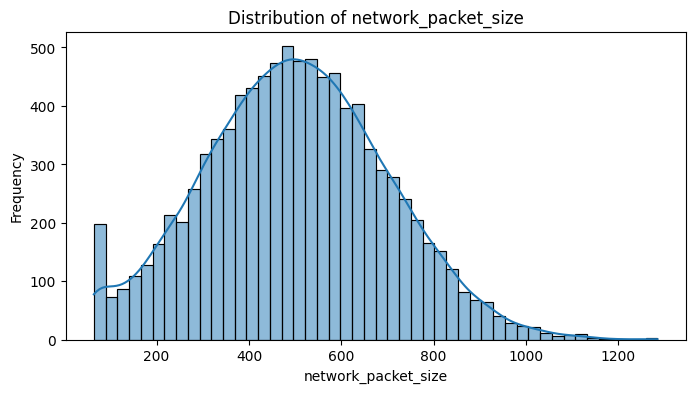

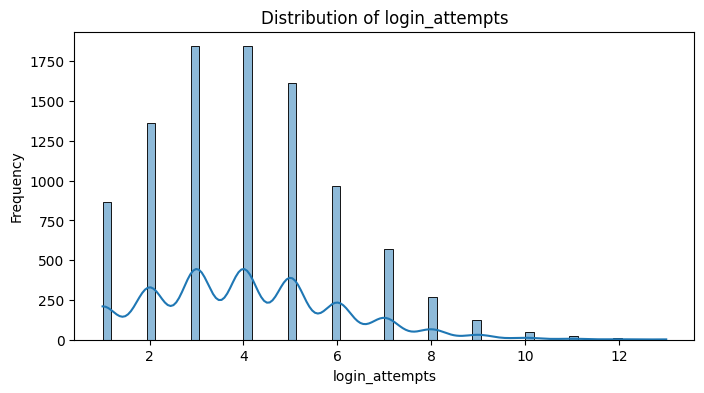

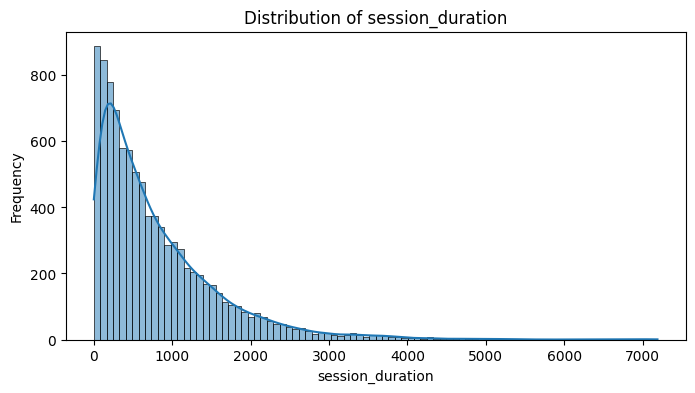

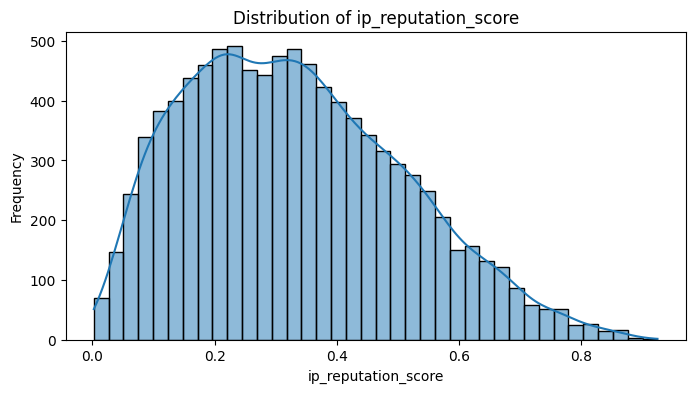

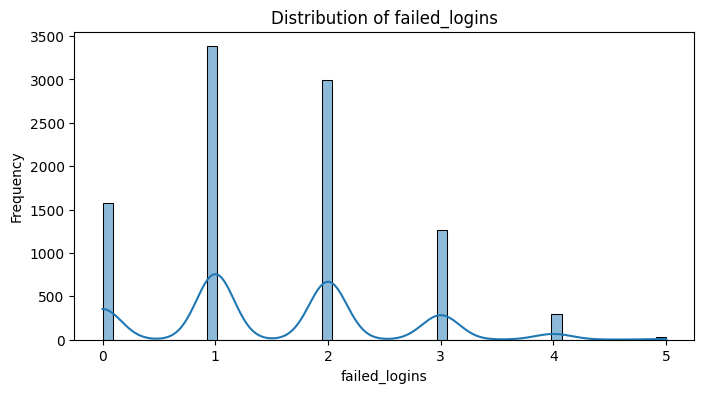

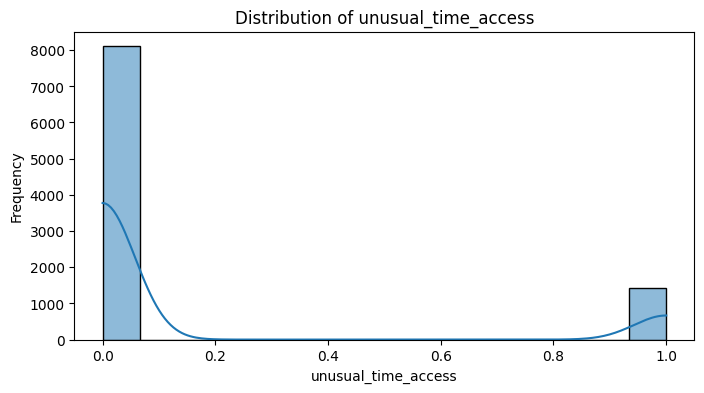

In [ ]:
numerical_features = data.select_dtypes(include=np.number).columns.tolist()
numerical_features.remove('attack_detected') # Exclude the target variable

for feature in numerical_features:
    plt.figure(figsize=(8, 4))
    sns.histplot(data[feature], kde=True)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()

#### Visualize distributions of categorical features

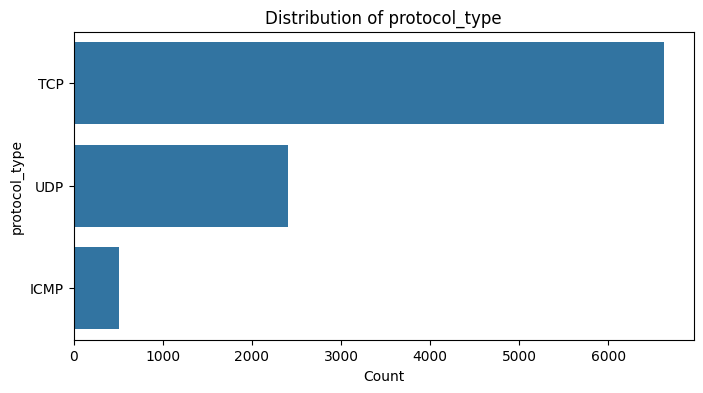

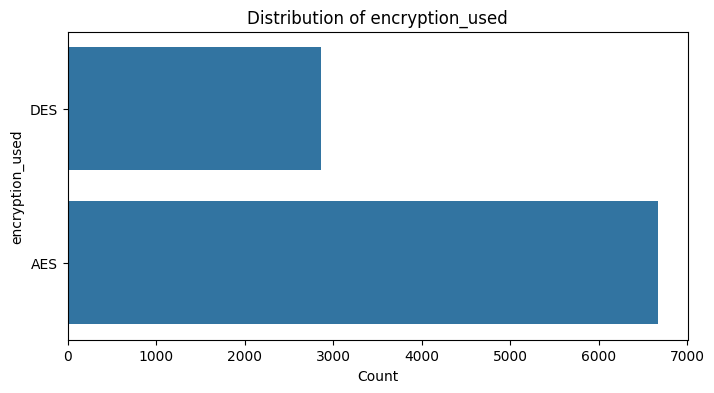

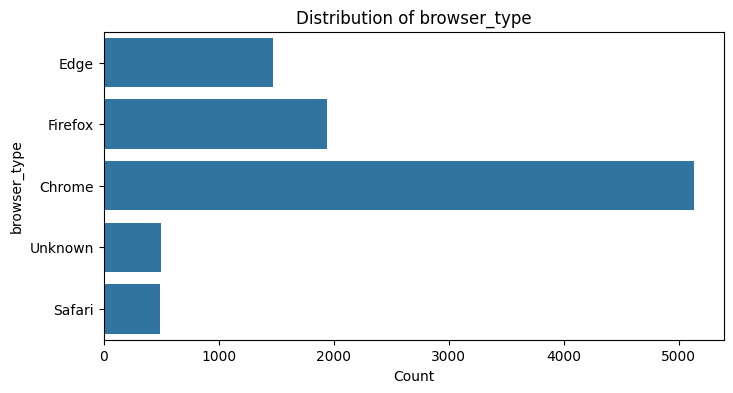

In [ ]:
categorical_features = data.select_dtypes(include='object').columns.tolist()
for feature in categorical_features:
    plt.figure(figsize=(8, 4))
    sns.countplot(y=feature, data=data)
    plt.title(f'Distribution of {feature}')
    plt.xlabel('Count')
    plt.ylabel(feature)
    plt.show()

#### Class imbalance of target variable

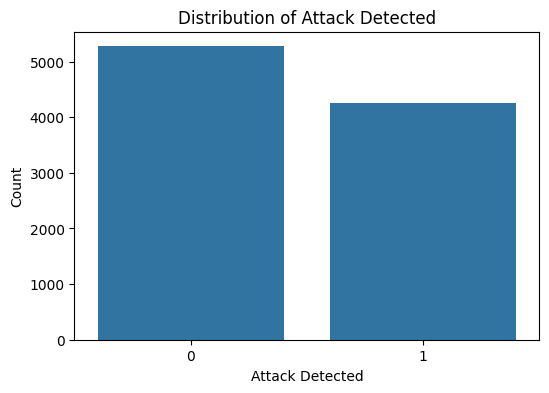

In [ ]:
plt.figure(figsize=(6, 4))
sns.countplot(x='attack_detected', data=data)
plt.title('Distribution of Attack Detected')
plt.xlabel('Attack Detected')
plt.ylabel('Count')
plt.show()

We will implement a technique (e.g., SMOTE) to address the class imbalance of the '**attack_detected**' variable.

First, we will separate features and target, then apply SMOTE to address class imbalance.

In [ ]:
from imblearn.over_sampling import SMOTE

X = data.drop('attack_detected', axis=1)
y = data['attack_detected']

# Select only numerical and one-hot encoded categorical features for SMOTE
X_numerical = X.select_dtypes(include=np.number)
X_categorical = X.select_dtypes(include='object')
X_categorical = pd.get_dummies(X_categorical, drop_first=True)

# Combine numerical and categorical features
X_processed = pd.concat([X_numerical, X_categorical], axis=1)


smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_processed, y)

print("Original dataset shape:", y.shape)
print("Resampled dataset shape:", y_resampled.shape)
print("Resampled dataset value counts:\n", y_resampled.value_counts())

Original dataset shape: (9537,)
Resampled dataset shape: (10546,)
Resampled dataset value counts:
 attack_detected
1    5273
0    5273
Name: count, dtype: int64


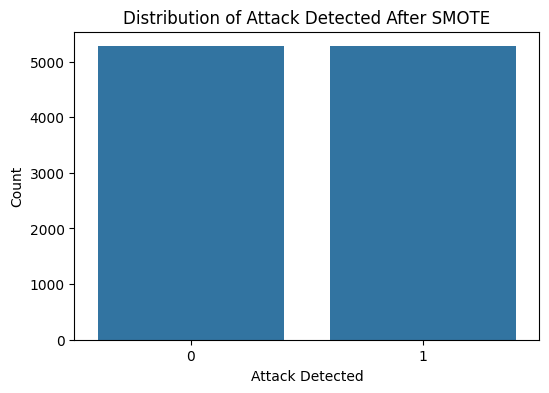

In [ ]:
plt.figure(figsize=(6, 4))
sns.countplot(x=y_resampled)
plt.title('Distribution of Attack Detected After SMOTE')
plt.xlabel('Attack Detected')
plt.ylabel('Count')
plt.show()

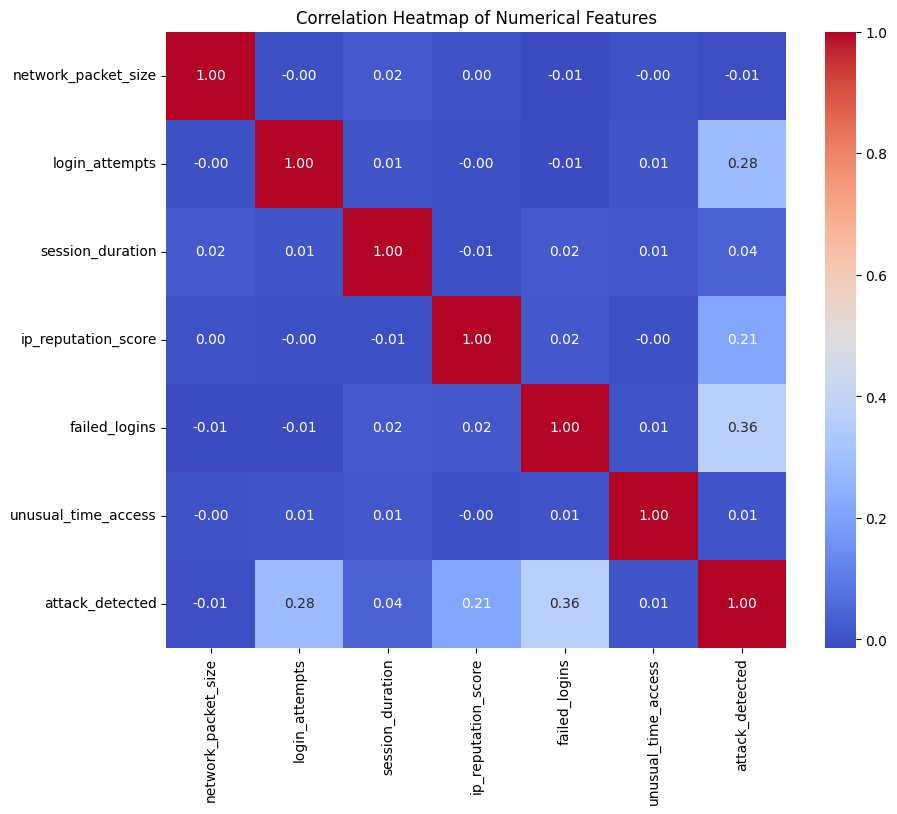

In [ ]:
# Select only numerical features for correlation analysis
numerical_data = data.select_dtypes(include=np.number)

# Calculate the correlation matrix
correlation_matrix = numerical_data.corr()

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

 Looking at the heatmap, here are some observations about the correlations between the numerical features in your dataset:

**login_attempts and failed_logins**: There is a noticeable positive correlation between login_attempts and failed_logins (correlation coefficient around 0.36). This is expected, as a higher number of login attempts is likely to result in a higher number of failed logins.

**ip_reputation_score and attack_detected**: There is a positive correlation between ip_reputation_score and attack_detected (correlation coefficient around 0.21). This suggests that sessions with higher IP reputation scores are somewhat more likely to be associated with detected attacks.

**network_packet_size and attack_detected**: The correlation between network_packet_size and attack_detected is very close to zero (-0.01), indicating a weak linear relationship.
session_duration and attack_detected: The correlation between session_duration and attack\_detected is also weak (0.04).

**unusual_time_access and attack_detected**: There is a weak positive correlation between unusual_time_access and attack\_detected (0.01).


Overall, while there are some expected correlations (like between login attempts and failed logins), the numerical features in this dataset don't show very strong linear correlations with each other or directly with the attack_detected variable based on this heatmap. This doesn't mean these features aren't important for predicting attacks, but their relationship might be non-linear or involve interactions with other features

## Feature Engineering

In [17]:
# Create a new feature: ratio of failed logins to login attempts
# Add a small value (epsilon) to the denominator to avoid division by zero
X_processed['failed_login_ratio'] = X_processed['failed_logins'] / (X_processed['login_attempts'] + 1e-6)

display(X_processed.head())

,network_packet_size,login_attempts,session_duration,ip_reputation_score,failed_logins,unusual_time_access,protocol_type_TCP,protocol_type_UDP,encryption_used_DES,browser_type_Edge,browser_type_Firefox,browser_type_Safari,browser_type_Unknown,failed_login_ratio
0,599,4,492.983263,0.606818,1,0,True,False,True,True,False,False,False,0.250000
1,472,3,1557.996461,0.301569,0,0,True,False,True,False,True,False,False,0.000000
2,629,3,75.044262,0.739164,2,0,True,False,True,False,False,False,False,0.666666
3,804,4,601.248835,0.123267,0,0,False,True,True,False,False,False,True,0.000000
4,453,5,532.540888,0.054874,1,0,True,False,False,False,True,False,False,0.200000


In [18]:
# Create polynomial features for login_attempts and failed_logins
X_processed['login_attempts_sq'] = X_processed['login_attempts']**2
X_processed['failed_logins_sq'] = X_processed['failed_logins']**2

display(X_processed.head())

,network_packet_size,login_attempts,session_duration,ip_reputation_score,failed_logins,unusual_time_access,protocol_type_TCP,protocol_type_UDP,encryption_used_DES,browser_type_Edge,browser_type_Firefox,browser_type_Safari,browser_type_Unknown,failed_login_ratio,login_attempts_sq,failed_logins_sq
0,599,4,492.983263,0.606818,1,0,True,False,True,True,False,False,False,0.250000,16,1
1,472,3,1557.996461,0.301569,0,0,True,False,True,False,True,False,False,0.000000,9,0
2,629,3,75.044262,0.739164,2,0,True,False,True,False,False,False,False,0.666666,9,4
3,804,4,601.248835,0.123267,0,0,False,True,True,False,False,False,True,0.000000,16,0
4,453,5,532.540888,0.054874,1,0,True,False,False,False,True,False,False,0.200000,25,1
